In [1]:
pip install git+https://github.com/AdamCobb/hamiltorch

  Cloning https://github.com/AdamCobb/hamiltorch to /tmp/pip-req-build-hvh1wspf
  Running command git clone --filter=blob:none --quiet https://github.com/AdamCobb/hamiltorch /tmp/pip-req-build-hvh1wspf
  Resolved https://github.com/AdamCobb/hamiltorch to commit ec972d4686385f7839d8f062e6a7a13365f00174
  Preparing metadata (setup.py) ... done
  Created wheel for hamiltorch: filename=hamiltorch-0.4.1-py3-none-any.whl size=20806 sha256=6b7e297a450723da47219a94af455dcf2bde7ea0aebdc8b1133c3dc8049dcb80
  Stored in directory: /tmp/pip-ephem-wheel-cache-px6kkgak/wheels/fe/87/94/9c0743e518e47f9ef7e6a31bbffa0a8f0463067b7146372625
Successfully built hamiltorch


In [2]:
import torch
import hamiltorch
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import numpy as np

%matplotlib inline

In [3]:
hamiltorch.set_random_seed(123)
torch.manual_seed(123)
np.random.seed(123)
device = 'cpu'

In [4]:
from sympy import symbols, cosh, diff, simplify

# Define symbols
x, r, H, g, K, v, ve, phi = symbols('x r H g K v ve phi')

# Define the solution u
u = (g*K/v) * (1 - cosh(r*(x - H/2))/cosh(r*H/2))

# Compute the second derivative of u with respect to x
second_derivative = diff(u, x, x)

# Compute the expression for the forcing function
forcing_function = -ve/phi * second_derivative + (v*u/K)
print(forcing_function)
# Simplify the expression
forcing_function_simplified = simplify(forcing_function)

forcing_function_simplified


K*g*r**2*ve*cosh(r*(H/2 - x))/(phi*v*cosh(H*r/2)) + g*(1 - cosh(r*(-H/2 + x))/cosh(H*r/2))


g*(K*r**2*ve*cosh(r*(H/2 - x)) + phi*v*(cosh(H*r/2) - cosh(r*(H/2 - x))))/(phi*v*cosh(H*r/2))

In [5]:
lb = 0
rb = 1
X = np.linspace(lb, rb, 5)[:, None]
y = np.ones(X.shape[0])
print(X)
print(y)

[[0.  ]
 [0.25]
 [0.5 ]
 [0.75]
 [1.  ]]
[1. 1. 1. 1. 1.]


In [6]:
X = np.linspace(lb, rb, 5)[:, None]
y = np.ones(X.shape[0])[:,None]
print(X)
print(y)

[[0.  ]
 [0.25]
 [0.5 ]
 [0.75]
 [1.  ]]
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]]


In [7]:
import numpy as np

def generate(num, sigma, lam1, lam2):
    # Given parameters
    ve = v = 1e-3  # effective viscosity and fluid viscosity
    phi = 0.4  # porosity
    K = 1e-3  # permeability
    g = 1  # external force
    H = 1  # channel width, implicit from the domain [0,1]

    # Calculate r based on given relationship
    r = np.sqrt(v * phi / (ve * K))

    # New positions interval [0, 1]
    lb = 0
    rb = 1
    X = np.linspace(lb, rb, num)[:, None]
    y = np.ones(X.shape[0])[:, None] * lam1

    # Calculate boundary conditions
    lb_val = (K/v) * (1 - np.cosh(r*(lb - H/2))/np.cosh(r*H/2)) * lam2
    rb_val = (K/v) * (1 - np.cosh(r*(rb - H/2))/np.cosh(r*H/2)) * lam2

    # Reshape boundary values to match dimensions of y
    lb_val = lb_val.reshape(1, -1)
    rb_val = rb_val.reshape(1, -1)

    # Concatenate boundary points
    X = np.concatenate([X, np.array([[lb], [rb]])], axis=0)
    y = np.concatenate([y, lb_val, rb_val], axis=0)

    # Add noise to the forcing term
    y = y * (1 + sigma * np.random.randn(*y.shape))

    return X, y
(X,y) = generate(10,0.01,1,1/100)
print(X)
print(y)

[[0.        ]
 [0.11111111]
 [0.22222222]
 [0.33333333]
 [0.44444444]
 [0.55555556]
 [0.66666667]
 [0.77777778]
 [0.88888889]
 [1.        ]
 [0.        ]
 [1.        ]]
[[0.98914369]
 [1.00997345]
 [1.00282978]
 [0.98493705]
 [0.994214  ]
 [1.01651437]
 [0.97573321]
 [0.99571087]
 [1.01265936]
 [0.9913326 ]
 [0.        ]
 [0.        ]]


In [8]:
class PoissonPINN(torch.nn.Module):
    def __init__(self, width, lam1, lam2):
        super(PoissonPINN, self).__init__()
        self.fnn = nn.Sequential(
            nn.Linear(1, width),
            nn.Tanh(),
            nn.Linear(width, width),      #deifnisce 1 input layer, 1 hidden layer e 1 ouput layer
            nn.Tanh(),
            nn.Linear(width, 1)
        )
        self.lam1 = lam1
        self.lam2 = lam2

    def forward(self, X):
        x = X[:-2].requires_grad_(True)
        u = self.fnn(x)
        u_x = torch.autograd.grad(u, x, grad_outputs = torch.ones_like(u), create_graph = True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs = torch.ones_like(u), create_graph = True)[0]
        u_bd = self.fnn(X[-2:])
        nu_e = nu = 1e-3
        phi = 0.4
        K = 1e-3
        lhs = -nu_e/phi * u_xx + nu * u / K
        return torch.cat([self.lam1 * lhs, u_bd * self.lam2], dim = 0)

In [9]:
width = 50
sigma = 0.1
lam1 = 1
lam2 = 100
net = PoissonPINN(width, lam1, lam2)
for param in net.parameters():
    torch.nn.init.normal_(param)

In [10]:
train_num = 64
test_num = 100

X_train, y_train = generate(train_num, sigma, lam1, lam2)
X_test, y_test = generate(test_num, 0, lam1, lam2)
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)

X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

In [11]:
tau_list = [] #qui ci saranno tanti uni quanti sono i parametri nella NN
tau = 1.#/100. # iris 1/10
for w in net.parameters():
    tau_list.append(tau)
tau_list = torch.tensor(tau_list).to(device)

In [ ]:
params_init = hamiltorch.util.flatten(net).to(device).clone()

# May need to tune step_size and L to make sure acceptance rate is around 0.5-0.8
step_size = 0.0006
burn = 2000
num_samples = 20000
L = 4
params_hmc = hamiltorch.sample_model(net, X_train, y_train, model_loss='regression', params_init=params_init, num_samples=num_samples,
                                     step_size=step_size, burn = burn, num_steps_per_sample=L,tau_list=tau_list, tau_out=1)

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples     | Samples/sec

Acceptance Rate 0.89


In [ ]:
u_pred_list = []
for i in range(num_samples - burn):
    params = hamiltorch.util.unflatten(net, params_hmc[i])
    hamiltorch.util.update_model_params_in_place(net, params)
    u_pred = net.fnn(X_test)[:-2]
    u_pred_list.append(u_pred)
u_pred = torch.stack(u_pred_list)

In [ ]:
u_mean = torch.mean(u_pred, dim = 0)
u_std = torch.std(u_pred, dim = 0)
u_up, u_low = u_mean - 2 * u_std, u_mean + 2 * u_std

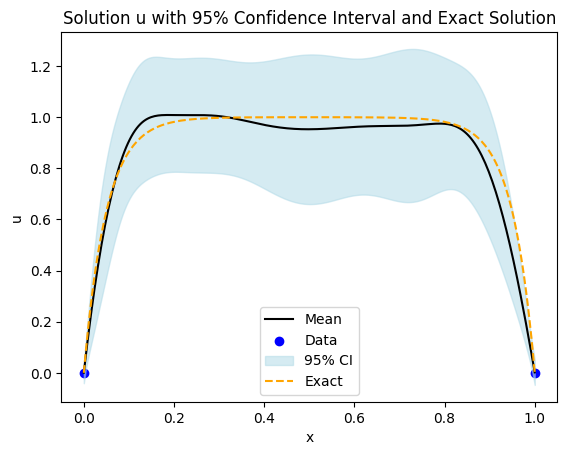

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Provided parameters
ve = v = 1e-3  # effective viscosity and fluid viscosity
phi = 0.4  # porosity
K = 1e-3  # permeability
g = 1  # external force
H = 1  # channel width, implicit from the domain [0,1]

# Calculate r based on given relationship
r = np.sqrt(v * phi / (ve * K))

# Convert X_test from PyTorch tensor to NumPy array and remove the last two elements
x_test_np = X_test[:-2].detach().cpu().numpy().squeeze()

# Calculate the exact solution u for each x in x_test_np
u_exact = (g * K / v) * (1 - np.cosh(r * (x_test_np - H / 2)) / np.cosh(r * H / 2))

# Plot the mean prediction
plt.plot(x_test_np, u_mean.detach().cpu().numpy(), label='Mean', color='black')

# Scatter plot for the observed data points
plt.scatter(X_train[-2:].detach().cpu().numpy(), y_train[-2:].detach().cpu().numpy() / lam2, label='Data', color='blue')

# Ensure u_low and u_up are one-dimensional
u_low_1d = u_low.squeeze().detach().cpu().numpy()
u_up_1d = u_up.squeeze().detach().cpu().numpy()

# Confidence Interval (CI) shading with a darker shade
plt.fill_between(x_test_np,
                 u_low_1d,
                 u_up_1d,
                 alpha=0.5,  # Use a darker shade by increasing alpha
                 color='lightblue',
                 label='95% CI')

# Plot the exact solution
plt.plot(x_test_np, u_exact, label='Exact', color='orange', linestyle='--')

# Add labels and legend
plt.legend()
plt.ylabel('u')
plt.xlabel('x')
plt.title('Solution u with 95% Confidence Interval and Exact Solution')
plt.show()



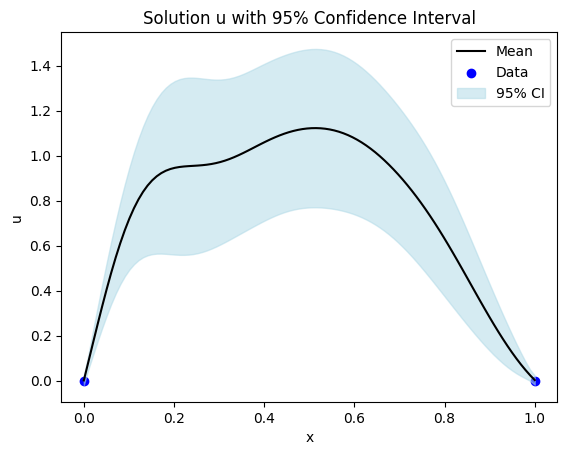

In [ ]:

import torch
import matplotlib.pyplot as plt
import numpy as np

# Plot the mean prediction
plt.plot(X_test[:-2].detach().cpu().numpy(), u_mean.detach().cpu().numpy(), label='Mean', color='black')


# Scatter plot for the observed data points
plt.scatter(X_train[-2:].detach().cpu().numpy(), y_train[-2:].detach().cpu().numpy()/lam2, label='Data', color='blue')

# Ensure u_low and u_up are one-dimensional
u_low_1d = u_low.squeeze().detach().cpu().numpy()
u_up_1d = u_up.squeeze().detach().cpu().numpy()

# Confidence Interval (CI) shading with a darker shade
plt.fill_between(X_test[:-2].squeeze().detach().cpu().numpy(),
                 u_low_1d,
                 u_up_1d,
                 alpha=0.5,  # Use a darker shade by increasing alpha
                 color='lightblue',
                 label='95% CI')

# Add labels and legend
plt.legend()
plt.ylabel('u')
plt.xlabel('x')
plt.title('Solution u with 95% Confidence Interval')
plt.show()